In [2]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [133]:
class DiRect(object):
    def __init__(self, f, bounds, epsilon=0.0001, max_feval=20, max_iter=10,
    max_rectdiv=100, minimize=True):
        self.f = f  # should take (D,) nparray as input
        self.bounds = bounds  # Dx2 [[lower, upper]]
        self.epsilon = epsilon
        self.max_feval = max_feval
        self.max_iter = max_iter
        self.minimize = minimize
        
        if not self.minimize:  # means maximization problem
            self.f_wrap = lambda x: -self.f(x)
        else:
            self.f_wrap = self.f

        self.scale = bounds[:,1] - bounds[:,0]
        self.shift = bounds[:,0]
        self.D = bounds.shape[0]
        
        self.curr_opt = np.inf
        self.x_at_opt = None
        self.n_feval = 0
        self.n_iter = 0
        self.n_rectdiv = 0
        self.d_rect = {}        
        self.l_hist = []

        assert isinstance(bounds, np.ndarray)
        assert len(bounds.shape) == 2
        assert bounds.shape[1] == 2
        assert np.all(self.scale > 0.)
        ## TODO: other assertions

    def u2r(self, unit_coord):
        """unit to real: map a coordinate 
        in unit hypercube to one in the actual rectangle"""
        return unit_coord * self.scale + self.shift
    
    def divide_rectangle(self, po_rect):
        D = self.D
        maxlen = np.max(po_rect.sides)
        gap = maxlen / 3.
        d_new_rects = {}
        
        self.d_rect[po_rect.d2].remove(po_rect)
        
        # only the longest sides are divided
        maxlen_sides = list(np.nonzero(po_rect.sides == maxlen)[0])
        for side_idx in maxlen_sides:
            d_new_rects[side_idx] = []
            
            new_center_u = po_rect.center.copy()
            new_center_u[side_idx] += gap
            new_fval_u = self.f_wrap(self.u2r(new_center_u))
            d_new_rects[side_idx].append(Rectangle(new_center_u, new_fval_u, po_rect.sides.copy()))
            self.l_hist.append((self.u2r(new_center_u), new_fval_u))
            
            new_center_l = po_rect.center.copy()
            new_center_l[side_idx] -= gap
            new_fval_l = self.f_wrap(self.u2r(new_center_l))
            d_new_rects[side_idx].append(Rectangle(new_center_l, new_fval_l, po_rect.sides.copy()))
            self.l_hist.append((self.u2r(new_center_l), new_fval_l))
        
        maxlen_sides = sorted(maxlen_sides, 
                              key=lambda x: min([t.f_val for t in d_new_rects[x]]))
        
        for i in xrange(len(maxlen_sides)):
            for side_idx in maxlen_sides[i:]:
                po_rect.sides[side_idx] /= 3.
                for each_rect in d_new_rects[side_idx]:
                    each_rect.sides[side_idx] /= 3.
                    
        
        for l_rect in d_new_rects.values():
            for each_rect in l_rect:
                d2 = each_rect.d2 
                if d2 not in self.d_rect:
                    self.d_rect[d2] = [each_rect]
                else:
                    if each_rect.f_val < self.d_rect[d2][0].f_val:
                        self.d_rect[d2].insert(0, each_rect)
                    else:
                        self.d_rect[d2].append(each_rect)
                        
        if po_rect.d2 not in self.d_rect:
            self.d_rect[po_rect.d2] = [po_rect]
        else:
            if po_rect.f_val < self.d_rect[po_rect.d2][0].f_val:
                self.d_rect[po_rect.d2].insert(0, po_rect)
            else:
                self.d_rect[po_rect.d2].append(po_rect)
        
        # remove empty list from the dictionary
        for dd in [key for key in self.d_rect if len(self.d_rect[key]) == 0]:
            self.d_rect.pop(dd)
        
    def run(self):
        D = self.D
        
        # initialize
        c = np.array([0.5] * D)
        f_val = self.f_wrap(self.u2r(c))
        s = np.array([1.]*D)
        rect = Rectangle(c, f_val, s)
        
        self.d_rect[rect.d2] = [rect]
        self.l_hist.append((self.u2r(c), f_val))
        self.n_feval += 1
        self.curr_opt = f_val
        
        for i in xrange(self.max_iter):
            print i
            for key, val in self.d_rect.items():
                for r in val:
                    print key, r.center, r.f_val, r.sides
            
            # select potentially optimal rectangles
            l_potentially_optimal = [l[0] for l in self.d_rect.values()]
            
            for po_rect in l_potentially_optimal:
                self.divide_rectangle(po_rect)
                
        return self.curr_opt, self.x_at_opt, self.l_hist
    
class Rectangle(object):
    def __init__(self, center, f_val, sides):
        self.center = center
        self.f_val = f_val
        self.sides = sides
        self.__str__ = f_val
        
    @property
    def d2(self):
        return np.sum((self.sides / 2.) ** 2)

0
0.25 [ 0.5] 0.25 [ 1.]
1
0.0277777777778 [ 0.16666667] 0.0277777777778 [ 0.33333333]
0.0277777777778 [ 0.83333333] 0.694444444444 [ 0.33333333]
0.0277777777778 [ 0.5] 0.25 [ 0.33333333]
2
0.0277777777778 [ 0.83333333] 0.694444444444 [ 0.33333333]
0.0277777777778 [ 0.5] 0.25 [ 0.33333333]
0.00308641975309 [ 0.05555556] 0.00308641975309 [ 0.11111111]
0.00308641975309 [ 0.27777778] 0.0771604938272 [ 0.11111111]
0.00308641975309 [ 0.16666667] 0.0277777777778 [ 0.11111111]
3
0.0277777777778 [ 0.5] 0.25 [ 0.33333333]
0.000342935528121 [ 0.01851852] 0.000342935528121 [ 0.03703704]
0.000342935528121 [ 0.09259259] 0.00857338820302 [ 0.03703704]
0.000342935528121 [ 0.05555556] 0.00308641975309 [ 0.03703704]
0.00308641975309 [ 0.27777778] 0.0771604938272 [ 0.11111111]
0.00308641975309 [ 0.16666667] 0.0277777777778 [ 0.11111111]
0.00308641975309 [ 0.94444444] 0.891975308642 [ 0.11111111]
0.00308641975309 [ 0.72222222] 0.521604938272 [ 0.11111111]
0.00308641975309 [ 0.83333333] 0.694444444444 [ 0

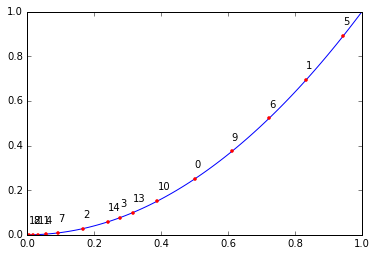

In [135]:
func_1d = lambda x: (x**2)[0]
b = np.array([[0,1]])
direct = DiRect(func_1d, b, max_iter=4)
direct.run()
# print direct.l_hist
plt.figure()
x = np.linspace(b[0,0], b[0,1], 100).reshape((1,-1))
y = func_1d(x)
plt.plot(x.flatten(),y)
i = 0
for hist in direct.l_hist:
    plt.plot(hist[0], hist[1], 'r.')
    plt.text(hist[0], hist[1]+0.05, i)
    i += 1

In [131]:
a = np.array([1,2,3])
b = a.copy()
a[1] += 1
print a
print b

[1 3 3]
[1 2 3]


In [80]:
a = {1:2, 3:4}
a.(1)
print a

{3: 4}


In [6]:
a = np.array([1,2,3])
b = a.copy()
a[2] += 1
print a
print b

[1 2 4]
[1 2 3]


In [7]:
a = [1,2,3]
b = a[:]
a[2] += 1
print a
print b

[1, 2, 4]
[1, 2, 3]


In [8]:
a = [1, np.array([2,3])]
b = a[:]
a[1][0] += 1
print a
print b

[1, array([3, 3])]
[1, array([3, 3])]
